In [1]:
import baltic as bt
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from datetime import datetime as dt
from datetime import timedelta
import matplotlib.lines as mlines
import time
from io import StringIO
import altair as alt
import numpy as np
from zipfile import ZipFile


In [2]:
tree12=bt.loadNexus('/Users/mparedes/Desktop/new_variants_pull/mcc_tree_random_3000.trees', absoluteTime = False)
tree12.setAbsoluteTime(2022.1753424657534)

In [3]:
clist=[(0.0,'#3B76AF'),
       (0.5,'grey'),
       (1.0,'#E68033')]

host_cmap = mpl.colors.LinearSegmentedColormap.from_list('mycmap',clist)

In [4]:
def convertDate(x,start,end):
    """ Converts calendar dates between given formats """
    return dt.strftime(dt.strptime(x,start),end)

In [5]:
for k in tree12.Objects:
    if "typeTrait.set" not in k.traits:
        k.traits.update({'typeTrait.set': []})
    if "typeTrait" not in k.traits:
        k.traits.update({'typeTrait': []})
    if k.traits['typeTrait'] == []:
        k.traits.update({'typeTrait': 'none'})

In [8]:
division_order = ['North_King_County', 'South_King_County']
exclusions = ['none', 'root', 'ancestor']

In [9]:
##this can be used to find root locations and make predefined clusters into individual subtrees.
def enumerate_subtrees_clusters(tree):
    
    traitName="typeTrait"

    tree.root.traits[traitName]='ancestor' ## give root node some trait value that's different from what the actual tree root has, so it registers as a switch

    tree_strings={division:[] for division in division_order}
    subtype_trees=[]

    for k in sorted(tree.Objects,key=lambda x:x.height):
        kp=k.parent     # kp is the parent node of k
        
        ## get current node's (k) and its parent's (kp) trait states
        kloc=k.traits[traitName]      # kloc = trait of k; kc = trait of k; they are the same thing
        if traitName in k.parent.traits:       # if parent has a trait block, use that trait, else assign to ancestor
            kploc=kp.traits[traitName]              # kploc = trait of parental node
        else:
            kploc='ancestor'

        kc=kloc     
        ## if states do not match
        if (kloc != kploc) & (kploc in exclusions):      # if node and parental node do not have the same trait
            #N_children=len(k.leaves)
            traverse_condition=lambda w:w.traits[traitName] in division_order     # traverse tree for all nodes whose traitname = kc
            #print('subtree resulting from %s>%s switch, traversing within %s'%(kploc,kloc,kloc))
            subtree=tree.subtree(k,traverse_condition=traverse_condition) #traitName = traitName ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state

            if subtree != None:
                subtree.traverse_tree()
                subtree.sortBranches()

                #tree_strings[kloc].append(subtree.toString()) ## remember subtree string, subtree object itself
                subtype_trees.append((kploc, kloc, subtree))
    
    return(subtype_trees)

In [10]:
division_order = ['North_King_County', 'South_King_County']
exclusions = ['none', 'root', 'ancestor']

In [11]:
subtype_trees = enumerate_subtrees_clusters(tree12)


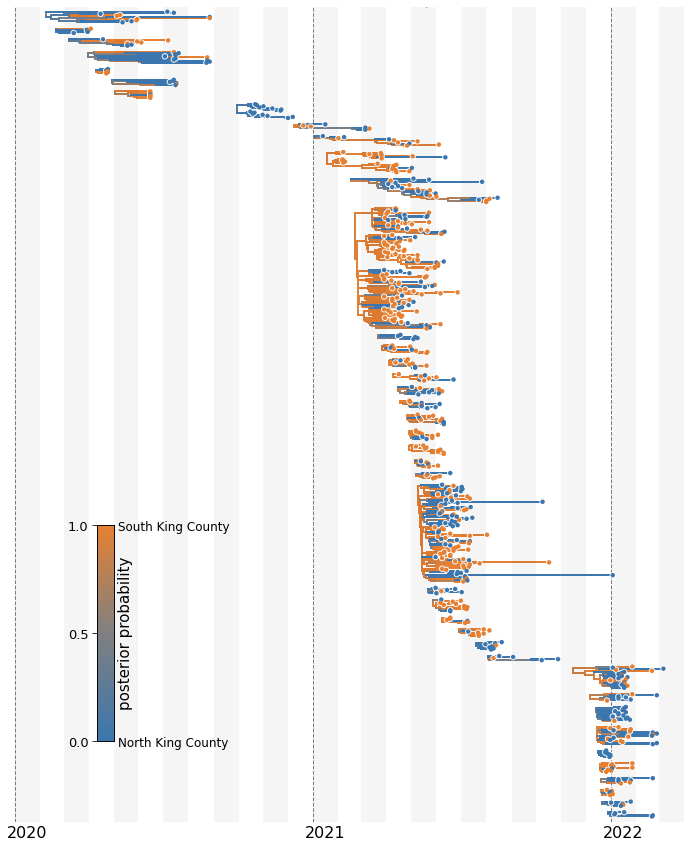

In [19]:
fig,ax = plt.subplots(figsize=(12,15),facecolor='w')
cumulativeY=0
branchWidth=2
for t,tr in enumerate(sorted(subtype_trees,key=lambda x:(-x[2].root.absoluteTime))): ## iterate over extracted subtrees sorted according to their root height and their size
    origin,root,loc_tree=tr

    for k in loc_tree.Objects:
        c='k'
        if 'South_King_County' in k.traits['typeTrait.set']:
            hidx=k.traits['typeTrait.set'].index('South_King_County')
            c=host_cmap(k.traits['typeTrait.set.prob'][hidx])
        else:
            c=host_cmap(0.0)

        z=1
        if k.traits['typeTrait']=='North_King_County':
            z=2

        x=k.absoluteTime
        y=k.y+cumulativeY

        xp=k.parent.absoluteTime
        if xp==0:
            xp=x

        if k.branchType=='leaf':
            ax.scatter(x,y,s=20,facecolor=c,edgecolor='none',zorder=4)
            ax.scatter(x,y,s=40,facecolor='w',edgecolor='none',zorder=3)
        else:
            yl=k.children[0].y+cumulativeY
            yr=k.children[-1].y+cumulativeY
            ax.plot([x,x],[yl,yr],color=c,lw=branchWidth,zorder=z)

        if loc_tree.Objects.index(k)!=0:
            ax.plot([x,xp],[y,y],color=c,lw=branchWidth,zorder=z)
    cumulativeY+=loc_tree.ySpan+5

every=12
xDates=['%04d-%02d-01'%(y,m) for y in range(2019,2023) for m in range(1,13)]

[ax.axvspan(bt.decimalDate(xDates[x]),bt.decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
ax.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])

ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
ax.tick_params(axis='x',labelsize=16,size=0)

[ax.axvline(i,ls='--',lw=1,color='grey',zorder=0) for i in range(2019,2023)]

        
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(size=0)
#ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xlim(bt.decimalDate('2020-01-01'),bt.decimalDate('2022-04-01'))
ax.set_ylim(-5,cumulativeY -15)

ax2 = fig.add_axes([0.22, 0.2, 0.02, 0.2])
mpl.colorbar.ColorbarBase(ax2, cmap=host_cmap,ticks=np.linspace(0.0,1.0,3))
ax2.tick_params(size=5,labelsize=13)
ax2.set_ylabel('posterior probability', size=15)
ax3=ax2.twinx()
ax3.set_ylim(0,1)
ax3.set_yticks([0.0,1.0])
ax3.set_yticklabels(['North King County','South King County'])
ax3.tick_params(size=0,labelsize=12)
plt.savefig('../figures/mcc_clusters_size_5.png',dpi=300,bbox_inches='tight')
plt.show()